In [ ]:
# Import key libraries
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F
import torch.random
from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchvision.transforms as T
from torchvision.transforms import v2
import torchvision.models as models
import torchvision.datasets as datasets
from torchvision.io import read_image

from PIL import Image

import shutil
import subprocess
from pathlib import Path
import os
import sys
from google.colab import drive
import requests
import zipfile
from timeit import default_timer as timer
import time
import random

from tqdm.auto import tqdm

from typing import List, Tuple, Dict, Optional, Union

import numpy as np

import matplotlib.pyplot as plt

import importlib

try:
  from torchinfo import summary
except:
  subprocess.run(["pip", "install", "torchinfo"],check=True)
  from torchinfo import summary

helper_function_path = "/content/Helper Functions"
if os.path.exists(helper_function_path):
  shutil.rmtree(helper_function_path)

URL = "https://github.com/anirguha/Python-2/raw/refs/heads/master/Helper%20Functions/copy_helper_functions.py"
code = requests.get(URL, timeout=30).text
exec(compile(code, URL, "exec"), {"__name__": "__main__"})

if os.path.exists("/content/Helper Functions"):
  for dirpath, dirnames, filenames in os.walk("/content/Helper Functions", topdown=True):
    sys.path.append(dirpath)
else:
  print("\u274c Error in loading Helper functions ")

import data_setup, engine, model_builder, utils, predict, icons

from helpers import download_data, set_seeds, plot_loss_curves

from icons import SUCCESS, ERROR, WARNING, INFO

device = "cuda" if torch.cuda.is_available() else "cpu"



Copying folder to working directory ...
Cleaning up cloned repository ...
✅ Copy complete!
[INFO] Predicting on None


# Download 20% sample of Food-101 from GitHub

In [ ]:
import urllib.request

URL = "https://github.com/anirguha/Python-2/raw/refs/heads/master/Machine%20Learning%20Datasets/data/pizza_steak_sushi_20_percent.zip"

local_filename = "pizza_steak_sushi_20_percent.zip"

try:
  urllib.request.urlretrieve(URL, local_filename)
  print(f"{SUCCESS} Data downloaded successfully")
except urllib.error.URLError as e:
  print(f"{ERROR} Error in downloading data {e}")

✅ Data downloaded successfully


In [ ]:
data_path = Path("/content/data")
img_path = data_path / "pizza_steak_sushi_20_percent"

if not os.path.exists(img_path):
  shutil.unpack_archive(local_filename, img_path, "zip")
  print(f"{SUCCESS} Data unpacked successfully")
else:
  print(f"{INFO} Data already exists at {img_path}")

if local_filename.endswith(".zip"):
  os.remove(local_filename)
  print(f"{SUCCESS} Downloaded zip file removed successfully")

✅ Data unpacked successfully
✅ Downloaded zip file removed successfully


# Create Image Transformer for EfficientNetB2 model

In [ ]:
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

transform_image = EfficientNet_B2_Weights.DEFAULT.transforms()

# Create DataLoaders

In [ ]:
train_dir = img_path / "train"
test_dir = img_path / "test"

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(   train_dir=train_dir,                                                            test_dir=test_dir,
transform=transform_image,
batch_size = BATCH_SIZE,
num_workers=NUM_WORKERS,
pin_memory=True,
device=device
)

# Import the weights from EfficientNet_B2 and train the model

In [ ]:
weights = EfficientNet_B2_Weights.DEFAULT
efficientnetb2_model = efficientnet_b2(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:00<00:00, 94.9MB/s]


In [ ]:
summary(model=efficientnetb2_model,
        input_size=(1,3,288,288),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])
#

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 288, 288]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 288, 288]     [1, 1408, 9, 9]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 288, 288]     [1, 32, 144, 144]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 288, 288]     [1, 32, 144, 144]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 144, 144]    [1, 32, 144, 144]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 144, 144]    [1, 32, 144, 144]    --                   --
│    └─Sequential (1)                                        [1, 32, 144, 144]    [1, 16, 144,

In [ ]:
for p in efficientnetb2_model.parameters():
  p.requires_grad = False

efficientnetb2_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
)

for p in efficientnetb2_model.classifier.parameters():
  p.requires_grad = True
#

In [ ]:
optimizer = torch.optim.Adam(params=efficientnetb2_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Train the model
efficientnetb2_model.to(device)

results_efficientnetb2 = engine.train(model=efficientnetb2_model,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9499 | train_acc: 55.4167 | test_loss: 0.7236 | test_acc: 85.1705
Epoch: 2 | train_loss: 0.7005 | train_acc: 83.5417 | test_loss: 0.5781 | test_acc: 93.4659
Epoch: 3 | train_loss: 0.5620 | train_acc: 88.1250 | test_loss: 0.4871 | test_acc: 91.9318
Epoch: 4 | train_loss: 0.4731 | train_acc: 87.5000 | test_loss: 0.4220 | test_acc: 94.7159
Epoch: 5 | train_loss: 0.4246 | train_acc: 90.8333 | test_loss: 0.3872 | test_acc: 94.7159
Epoch: 6 | train_loss: 0.3779 | train_acc: 92.2917 | test_loss: 0.3655 | test_acc: 94.0909
Epoch: 7 | train_loss: 0.3216 | train_acc: 93.1250 | test_loss: 0.3224 | test_acc: 95.6250
Epoch: 8 | train_loss: 0.2943 | train_acc: 93.9583 | test_loss: 0.2988 | test_acc: 96.2500
Epoch: 9 | train_loss: 0.2830 | train_acc: 93.5417 | test_loss: 0.2917 | test_acc: 96.2500
Epoch: 10 | train_loss: 0.2827 | train_acc: 94.1667 | test_loss: 0.2722 | test_acc: 95.0000


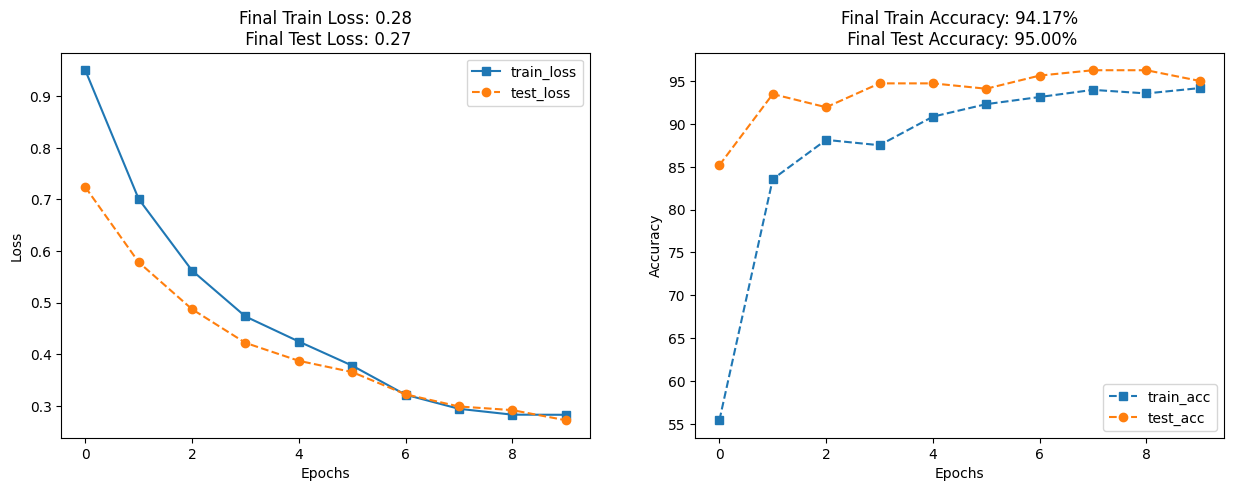

In [ ]:
# Plot the loss and accuracy curves

fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(results_efficientnetb2["train_loss"],"s-",label="train_loss")
ax[0].plot(results_efficientnetb2["test_loss"],"o--",label="test_loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title(f"Final Train Loss: {results_efficientnetb2['train_loss'][-1]:.2f}\n Final Test Loss: {results_efficientnetb2['test_loss'][-1]:.2f}")
ax[0].legend()

ax[1].plot(results_efficientnetb2["train_acc"],"s--",label="train_acc")
ax[1].plot(results_efficientnetb2["test_acc"],"o--",label="test_acc")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title(f"Final Train Accuracy: {results_efficientnetb2['train_acc'][-1]:.2f}%\n Final Test Accuracy: {results_efficientnetb2['test_acc'][-1]:.2f}%")
ax[1].legend()
plt.show();

In [ ]:
# Save the model
model_path = Path("/content/models")

if not os.path.exists(model_path):
  os.makedirs(model_path)

model_name = "efficientnetb2_model"
model_save_path = model_path / f"{model_name}.pth"

try:
  torch.save(obj=efficientnetb2_model.state_dict(),
           f=model_path / model_save_path)
  print(f"{SUCCESS} Model saved successfully")
except Exception as e:
  print(f"{ERROR} Error in saving model {e}")


✅ Model saved successfully


In [ ]:
# Load the model for prediction


model_path = model_save_path

# Build the same shape model you trained
model = efficientnet_b2(weights=None, num_classes=len(class_names)).to(device)

# Load checkpoint
state_dict = torch.load(model_path, map_location=device)

missing, unexpected = model.load_state_dict(state_dict, strict=False)
print("Loaded with:")
print("  missing_keys   :", missing)
print("  unexpected_keys:", unexpected)

Loaded with:
  missing_keys   : []
  unexpected_keys: []


In [ ]:
# download an image from WikiMedia
from download_image import download_image

image_to_download = random.choice(class_names)
print(f"Downloading image of {image_to_download}")

out_dir = "/content/images"

test_image_path = download_image(image_to_download, out_dir=out_dir)

ℹ️  Attempting: Wikimedia Commons -> https://upload.wikimedia.org/wikipedia/commons/d/d3/Sushi_making.jpg
✅  Saved: /content/images/sushi.jpg (source: Wikimedia Commons; attempts: 1)


torch.Size([3, 3024, 4032])


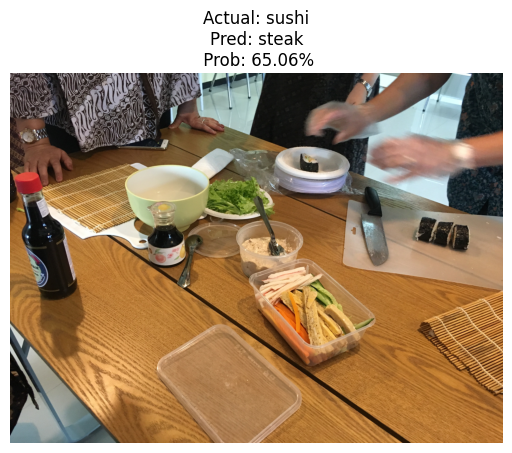

In [ ]:
image_path = test_image_path


from torchvision.io import read_image
image = read_image(str(image_path))
print(image.shape)
plt.imshow(image.permute(1,2,0))
plt.title(image_to_download)
plt.axis("off");

image_transformed = transform_image(image)

model.eval()
with torch.inference_mode():
  logits = model(image_transformed.unsqueeze(0).to(device))
pred_probs = torch.softmax(logits, dim=1)
pred_max_prob, pred_label = torch.max(pred_probs, dim=1)

plt.imshow(image.permute(1,2,0))
plt.title(f"Actual: {image_to_download}\nPred: {class_names[pred_label]}\n Prob: {pred_max_prob.item()*100:0.2f}%")
plt.axis("off")
plt.show();

# Train using ViT_16 model

Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_swag-9ac1b537.pth


100%|██████████| 331M/331M [00:20<00:00, 16.9MB/s]


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1904 | train_acc: 96.2500 | test_loss: 0.0224 | test_acc: 100.0000
Epoch: 2 | train_loss: 0.0377 | train_acc: 99.1667 | test_loss: 0.0107 | test_acc: 100.0000
Epoch: 3 | train_loss: 0.0222 | train_acc: 99.7917 | test_loss: 0.0077 | test_acc: 100.0000
Epoch: 4 | train_loss: 0.0151 | train_acc: 99.7917 | test_loss: 0.0073 | test_acc: 100.0000
Epoch: 5 | train_loss: 0.0124 | train_acc: 99.7917 | test_loss: 0.0078 | test_acc: 100.0000
Epoch: 6 | train_loss: 0.0105 | train_acc: 100.0000 | test_loss: 0.0069 | test_acc: 100.0000
Epoch: 7 | train_loss: 0.0096 | train_acc: 100.0000 | test_loss: 0.0067 | test_acc: 100.0000
Epoch: 8 | train_loss: 0.0092 | train_acc: 100.0000 | test_loss: 0.0069 | test_acc: 100.0000
Epoch: 9 | train_loss: 0.0088 | train_acc: 100.0000 | test_loss: 0.0065 | test_acc: 100.0000
Epoch: 10 | train_loss: 0.0091 | train_acc: 100.0000 | test_loss: 0.0071 | test_acc: 100.0000


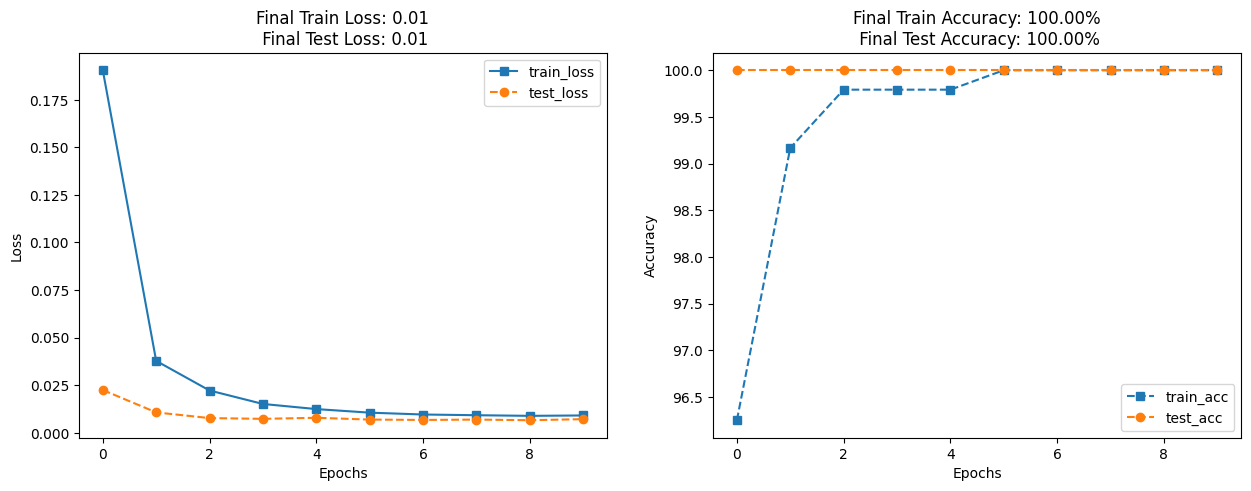

In [ ]:
# Using vit_b_16 pretrained model


from engine import train

from torchvision.models import vit_b_16, ViT_B_16_Weights

weights = ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
vit_b16_pretrained = vit_b_16(weights=weights).to(device) # Move model to device here

for p in vit_b16_pretrained.parameters():
  p.requires_grad = False

vit_b16_pretrained.heads.head = nn.Linear(in_features=768,
                                    out_features=len(class_names)).to(device) # Move the new head to device

for p in vit_b16_pretrained.heads.head.parameters():
  p.requires_grad = True

# Get the transform from the pretrained weights
transform = ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1.transforms()


BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dir = "data/pizza_steak_sushi_20_percent/train"
test_dir = "data/pizza_steak_sushi_20_percent/test"


train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=transform, # Use the transform directly from weights
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

# Define optimizer and loss function
optimizer = torch.optim.Adam(params=vit_b16_pretrained.parameters(),
                             lr=0.001,
                             betas=(0.9, 0.999),
                             eps=1e-08,
                             weight_decay=0.1,
                             amsgrad=False)

loss_fn = nn.CrossEntropyLoss()

results = train(model=vit_b16_pretrained,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device) # Use the corrected test_step function

fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(results["train_loss"],"s-",label="train_loss")
ax[0].plot(results["test_loss"],"o--",label="test_loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title(f"Final Train Loss: {results['train_loss'][-1]:.2f}\n Final Test Loss: {results['test_loss'][-1]:.2f}")
ax[0].legend()

ax[1].plot(results["train_acc"],"s--",label="train_acc")
ax[1].plot(results["test_acc"],"o--",label="test_acc")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title(f"Final Train Accuracy: {results['train_acc'][-1]:.2f}%\n Final Test Accuracy: {results['test_acc'][-1]:.2f}%")
ax[1].legend()
plt.show();



In [ ]:
# Save the model
model_path = Path("/content/models")

if not os.path.exists(model_path):
  os.makedirs(model_path)

model_name = "ViT_b16"
model_save_path = model_path / f"{model_name}.pth"

try:
  torch.save(obj=vit_b16_pretrained.state_dict(),
           f=model_path / model_save_path)
  print(f"{SUCCESS} Model saved successfully")
except Exception as e:
  print(f"{ERROR} Error in saving model {e}")


✅ Model saved successfully


In [ ]:
# Load the model for prediction


model_path = Path("/content/models")
model_save_path = model_path / "ViT_b16.pth"

# Build the same shape model you trained (use the vit_b_16 function, not the instance)
# Corrected: Specify image_size to match the trained model's input size (384 for SWAG weights)
model = vit_b_16(weights=None, image_size=384).to(device)

# Modify the classifier head to match the trained model
model.heads.head = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

# Load checkpoint
state_dict = torch.load(model_save_path, map_location=device)

missing, unexpected = model.load_state_dict(state_dict, strict=False)
print("Loaded with:")
print("  missing_keys   :", missing)
print("  unexpected_keys:", unexpected)

Loaded with:
  missing_keys   : []
  unexpected_keys: []


torch.Size([3, 3024, 4032])


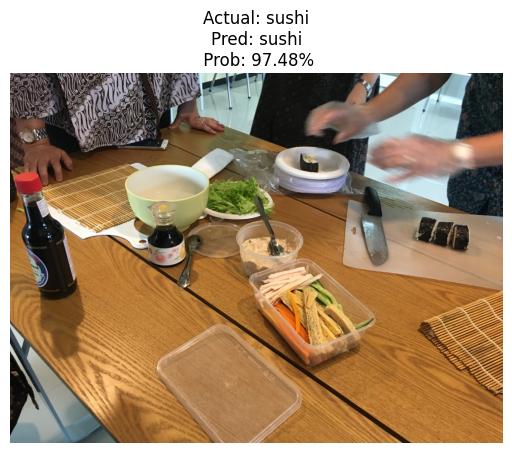

In [ ]:
image_path = test_image_path


from torchvision.io import read_image
image = read_image(str(image_path))
print(image.shape)
plt.imshow(image.permute(1,2,0))
plt.title(image_to_download)
plt.axis("off");

image_transformed = transform(image)

model.eval()
with torch.inference_mode():
  logits = model(image_transformed.unsqueeze(0).to(device))
pred_probs = torch.softmax(logits, dim=1)
pred_max_prob, pred_label = torch.max(pred_probs, dim=1)

plt.imshow(image.permute(1,2,0))
plt.title(f"Actual: {image_to_download}\nPred: {class_names[pred_label]}\n Prob: {pred_max_prob.item()*100:0.2f}%")
plt.axis("off")
plt.show();

# Get the size of each model

In [ ]:
effnetb2_path = Path("/content/models/efficientnetb2_model.pth")
vit_b16_path = Path("/content/models/ViT_b16.pth")

print(f"Effnet_B2 size: {Path(effnetb2_path).stat().st_size / (1024 * 1024):.2f} MB")
print(f"Vit_B16 size: {Path(vit_b16_path).stat().st_size / (1024 * 1024):.2f} MB")

Effnet_B2 size: 29.83 MB
Vit_B16 size: 328.48 MB


# Get the number of parameters for each model

In [ ]:
effnetb2_params = sum(p.numel() for p in efficientnetb2_model.parameters())
vit_b16_params = sum(p.numel() for p in vit_b16_pretrained.parameters())

effenetb2_trainable_params = sum(p.numel() for p in efficientnetb2_model.parameters() if p.requires_grad)
vit_b16_trainable_params = sum(p.numel() for p in vit_b16_pretrained.parameters() if p.requires_grad)

print(f"Effnet_B2 has {effnetb2_params:,} parameters")
print(f"Vit_B16 has {vit_b16_params:,} parameters")

print(f"Effnet_B2 has {effenetb2_trainable_params:,} trainable parameters")
print(f"Vit_B16 has {vit_b16_trainable_params:,} trainable parameters")

Effnet_B2 has 7,705,221 parameters
Vit_B16 has 86,092,803 parameters
Effnet_B2 has 4,227 trainable parameters
Vit_B16 has 2,307 trainable parameters


# Store all the parameters in a dictionary

In [ ]:
effnetb2_metrics = {}
effnetb2_metrics["size"] = f"{Path(effnetb2_path).stat().st_size / (1024 * 1024):.2f} MB"
effnetb2_metrics["params"] = f"{effnetb2_params:,}"
effnetb2_metrics["trainable_params"] = f"{effenetb2_trainable_params:,}"
effnetb2_metrics["accuracy"] = f"{results_efficientnetb2["test_acc"][-1]:.2f}%"
effnetb2_metrics["model_name"] = "EfficientNetB2"

vit_b16_metrics = {}
vit_b16_metrics["size"] = f"{Path(vit_b16_path).stat().st_size / (1024 * 1024):.2f} MB"
vit_b16_metrics["params"] = f"{vit_b16_params:,}"
vit_b16_metrics["trainable_params"] = f"{vit_b16_trainable_params:,}"
vit_b16_metrics["accuracy"] = f"{results["test_acc"][-1]:.2f}%"
vit_b16_metrics["model_name"] = "ViT_B_16"


print("Effnet_B2 metrics:")
print(effnetb2_metrics)
print("\nVit_B16 metrics:")
print(vit_b16_metrics)
#

Effnet_B2 metrics:
{'size': '29.83 MB', 'params': '7,705,221', 'trainable_params': '4,227', 'accuracy': '95.00%', 'model_name': 'EfficientNetB2'}

Vit_B16 metrics:
{'size': '328.48 MB', 'params': '86,092,803', 'trainable_params': '2,307', 'accuracy': '100.00%', 'model_name': 'ViT_B_16'}


#### EffnetB2 has a lower accuracy than ViT. However, the size is smaller which makes is suitable for deployment. Preidction time of ViT is also higher because of the higher number of trainable parameters.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
src = "/content/models"
dst = "/content/drive/MyDrive/Python/models"

shutil.copytree(src, dst)

'/content/drive/MyDrive/Python/models'

In [ ]:
drive.flush_and_unmount()